# Dual impact of empty sites (Z/AI) on spatial invasion and fixation

## Initialization

In [1]:
# import modules
import numpy as np
import pandas as pd
import networkx as nx
import multiprocess as mp
import random
import time
from sympy import *
## plot figures
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
### colormap
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib import rc
import matplotlib.patches as mpatches
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
rcParams['hatch.linewidth'] = 3
## compress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# save figures in the folder
_Figure_PATH_ = './figures/'
_Data_PATH_ = './data/'

# default colors of matplotlib
colors = ['C0', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', 
          '#17becf']
colors_heatmap = ['#E4B1BB', '#F5E2E7', '#A0AAC3', '#7282A0', '#2C3E5B']

## Symbolic Calculation

In [3]:
R, S, T, P, u = symbols('R, S, T, P, u', real = True) # payoff structure
alpha_A, alpha_B = symbols('alpha_A, alpha_B', real = True) # effects of empty sites
beta = symbols('beta', nonnegative = True) # selection strength
k = symbols('k', integer = True, positive = True) # network degree
N_e, N, i = symbols('N_e, N, i', integer = True, positive = True)
x, y = symbols('x, y', nonnegative = True)
# fractions of stratey A, strategy B, and strategy C (empty sites)
p_A, p_B, p_C, p_e = symbols('p_A, p_B, p_C, p_e', nonnegative = True) 
# fractions of edges
p_AA, p_AB, p_BA, p_BB = symbols('p_AA, p_AB, p_BA, p_BB', nonnegative = True)
p_AC, p_BC, p_CA, p_CB, p_CC = symbols('p_AC, p_BC, p_CA, p_CB, p_CC', nonnegative = True)
p_Ae, p_Be, p_eA, p_eB, p_ee = symbols('p_Ae, p_Be, p_eA, p_eB, p_ee', nonnegative = True)
# conditional probabilities: q_X|Y is the probability of X given Y
q_AA, q_BA, q_AB, q_BB = symbols('q_A|A, q_B|A, q_A|B, q_B|B', nonnegative = True)
# payoffs
pi_AA, pi_BA, pi_AB, pi_BB = symbols('pi^A_A, pi^B_A, pi^A_B, pi^B_B', real = True) 
init_printing(use_unicode = True) # for a good presentation of mathematics

## Appendix

### Equation (A8)

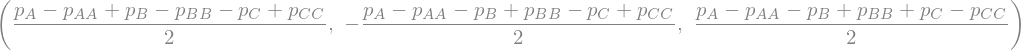

In [4]:
solutions = solve((Eq(p_A + p_B + p_C, 1), 
                   Eq(p_AB - p_BA, 0), Eq(p_BC - p_CB, 0), Eq(p_CA - p_AC, 0),
                   Eq(p_A - p_AA - p_AB - p_AC, 0), Eq(p_B - p_BA - p_BB - p_BC, 0), 
                   Eq(p_C - p_CA - p_CB - p_CC, 0)), (p_AB, p_BA, p_BC, p_CB, p_CA, p_AC))

factor(solutions[p_AB]), factor(solutions[p_BC]), factor(solutions[p_CA])

In [5]:
# conditional numbers of neighbors:
# k^X_Y is the number of X neighbors of the focal Y individual
k_AA, k_BA, k_CA = symbols('k^A_A, k^B_A, k^C_A', integer = True, nonnegative = True) 
k_AB, k_BB, k_CB = symbols('k^A_B, k^B_B, k^C_B', integer = True, nonnegative = True)
# conditional numbers of neighbors of neighbors with pair approximation
l_AA, l_BA, l_CA = symbols('l^A_A, l^B_A, l^C_A', integer = True, nonnegative = True) 
l_AB, l_BB, l_CB = symbols('l^A_B, l^B_B, l^C_B', integer = True, nonnegative = True) 
# payoffs and fitness
f_AA = exp(beta*((l_AA + 1)*R + l_BA*S + l_CA*alpha_A))
f_BA = exp(beta*((l_AB + 1)*T + l_BB*P + l_CB*alpha_B))
f_AB = exp(beta*(l_AA*R + (l_BA + 1)*S + l_CA*alpha_A))
f_BB = exp(beta*(l_AB*T + (l_BB + 1)*P + l_CB*alpha_B))

# multinomal distribution
# for easier calculation, consider first binomial and then trinomial
## neighbors
### of an A individual
dist_A = binomial(k, k_BA)*q_BA**k_BA*p_e**(k - k_BA) # substitute k with k - k_AA
### of a B individual
dist_B = binomial(k, k_BB)*q_BB**k_BB*p_e**(k - k_BB) # substitute k with k - k_AB
## neighbors 
### of an A neighbor except for the focal individual
bist_A = binomial(k, l_BA)*q_BA**l_BA*p_e**(k - l_BA) # substitute k with k - 1 - l_AA
### of a B neighbor except for the focal individual
bist_B = binomial(k, l_BB)*q_BB**l_BB*p_e**(k - l_BB) # substitute k with k - 1 - l_AB

### Equation (A18) and more

In [6]:
# cores
# Taylor expansion with respect to beta around beta = 0 to the first degree + O(beta^2)
## a focal B individual being replaced by a neighbor A individual
terms_AB = factor(k_AB*f_AB/(k_AB*f_AB + k_BB*f_BB + k_CB*1)).series(beta, x0 = 0, n = 2)
terms_AB = terms_AB.as_ordered_terms() # c_0 + c_1*beta + O(beta^2)
terms_AB0 = factor(terms_AB[0].subs({k_CB: k - k_AB - k_BB})) # constant term
terms_AB1 = factor(terms_AB[1].subs({k_CB: k - k_AB - k_BB})) # first-degree term
terms_AB1 = collect(collect(collect(collect(collect(collect(terms_AB1, l_AA), l_BA), l_CA), \
                                    l_AB), l_BB), l_CB)
## a focal A individual being replaced by a neighor B individual
terms_BA = factor(k_BA*f_BA/(k_AA*f_AA + k_BA*f_BA + k_CA*1)).series(beta, x0 = 0, n = 2)
terms_BA = terms_BA.as_ordered_terms()
terms_BA0 = factor(terms_BA[0].subs({k_CA: k - k_AA - k_BA}))
terms_BA1 = factor(terms_BA[1].subs({k_CA: k - k_AA - k_BA}))
terms_BA1 = collect(collect(collect(collect(collect(collect(terms_BA1, l_AA), l_BA), l_CA), \
                                    l_AB), l_BB), l_CB)

### Test

> a focal A individual

* #### one-fold

In [7]:
# multinomial distribution times k_AA
test_AA = summation(dist_A*k_AA, (k_BA, 0, k)) # summations wrt B and C
test_AA = cancel(test_AA.args[0]*test_AA.args[1].args[0][0]).subs({k: k - k_AA})
test_AA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AA, (k_AA, 0, k)) # summations wrt A
test_AA = cancel(factor(test_AA.args[0][0]))
test_AA = simplify(test_AA.subs({q_BA: 1 - p_e - q_AA}))
# multinomial distribution times k_BA
test_BA = cancel(summation(dist_A*k_BA, (k_BA, 0, k)).args[0][0]).subs({k: k - k_AA})
test_BA = summation(binomial(k, k_AA)*q_AA**k_AA*test_BA, (k_AA, 0, k))
test_BA = cancel(test_BA.args[0]*test_BA.args[1].args[0][0])
test_BA = simplify(test_BA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_CA = k - k_AA - k_BA
test_CA = summation(dist_A*(k - k_BA), (k_BA, 0, k))
test_CA = cancel(test_CA.args[0].args[0]*test_CA.args[0].args[1].args[0][0] + 
                 test_CA.args[1].args[0]*test_CA.args[1].args[1].args[0][0])
test_CA = cancel(factor(test_CA.subs({k: k - k_AA})))
test_CA = summation(binomial(k, k_AA)*q_AA**k_AA*test_CA, (k_AA, 0, k))
test_CA = cancel(test_CA.args[0].args[0]*test_CA.args[0].args[1].args[0][0] + 
                 test_CA.args[1].args[0]*test_CA.args[1].args[1].args[0][0] + 
                 test_CA.args[2].args[0]*test_CA.args[2].args[1]*test_CA.args[2].args[2].args[0][0])
test_CA = simplify(test_CA.subs({q_AA: 1 - q_BA - p_e}))
test_AA, test_BA, test_CA

* #### two-fold

In [8]:
# multinomial distribution times k_AA*k_BA
test_AABA = summation(dist_A*k_AA*k_BA, (k_BA, 0, k))
test_AABA = cancel(test_AABA.args[0]*test_AABA.args[1].args[0][0]).subs({k: k - k_AA})
test_AABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AABA, (k_AA, 0, k))
test_AABA = cancel(test_AABA.args[0]*test_AABA.args[1].args[0][0])
test_AABA = simplify(test_AABA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_BA*k_CA
test_BACA = summation(dist_A*k_BA*(k - k_BA), (k_BA, 0, k))
test_BACA = cancel(test_BACA.args[0].args[0]*test_BACA.args[0].args[1].args[0][0] + 
                   test_BACA.args[1].args[0]*test_BACA.args[1].args[1].args[0][0])
test_BACA = cancel(factor(test_BACA.subs({k: k - k_AA})))
test_BACA = summation(binomial(k, k_AA)*q_AA**k_AA*test_BACA, (k_AA, 0, k))
temps = [test_BACA.args[i] for i in range(3)]
test_BACA = cancel(np.sum([temps[i].args[0]*temps[i].args[1]*temps[i].args[2]*temps[i].args[3]*
                           temps[i].args[4].args[0][0] for i in range(3)]))
test_BACA = simplify(test_BACA.subs({q_AA: 1 - q_BA - p_e}))
# multinomial distribution times k_CA*k_AA
test_CAAA = summation(dist_A*(k - k_BA)*k_AA, (k_BA, 0, k))
temps = [test_CAAA.args[i] for i in range(2)]
test_CAAA = cancel(np.sum([temps[i].args[0]*temps[i].args[1]*temps[i].args[2].args[0][0] for i in range(2)]))
test_CAAA = cancel(factor(test_CAAA.subs({k: k - k_AA})))
test_CAAA = summation(binomial(k, k_AA)*q_AA**k_AA*test_CAAA, (k_AA, 0, k))
test_CAAA = cancel(test_CAAA.args[0].args[0]*test_CAAA.args[0].args[1].args[0][0] + 
                   test_CAAA.args[1].args[0]*test_CAAA.args[1].args[1].args[0][0] + 
                   test_CAAA.args[2].args[0]*test_CAAA.args[2].args[1]*test_CAAA.args[2].args[2].args[0][0])
test_CAAA = simplify(test_CAAA.subs({q_BA: 1 - q_AA - p_e}))
test_AABA, test_BACA, test_CAAA

In [9]:
# multinomial distribution times k_AA*k_AA
test_AAAA = summation(dist_A*k_AA**2, (k_BA, 0, k))
test_AAAA = cancel(test_AAAA.args[0]*test_AAAA.args[1].args[0][0]).subs({k: k - k_AA})
test_AAAA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AAAA, (k_AA, 0, k))
test_AAAA = cancel(factor(test_AAAA.args[0][0]))
test_AAAA = simplify(test_AAAA.subs({q_BA: 1 - p_e - q_AA}))
# multinomial distribution times k_BA*k_BA
test_BABA = summation(dist_A*k_BA**2, (k_BA, 0, k))
test_BABA = cancel(test_BABA.args[0][0].subs({k: k - k_AA}))
test_BABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_BABA, (k_AA, 0, k))
temps = [test_BABA.args[i] for i in range(3)]
test_BABA = cancel(np.sum([temps[i].args[0]*temps[i].args[1]*temps[i].args[2]*temps[i].args[3].args[0][0] 
                           for i in range(3)]))
test_BABA = simplify(test_BABA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_CA*k_CA
test_CACA = summation(dist_A*(k - k_BA)**2, (k_BA, 0, k))
test_CACA = cancel(test_CACA.args[0].args[0]*test_CACA.args[0].args[1].args[0][0] + 
                   test_CACA.args[1].args[0]*test_CACA.args[1].args[1]*test_CACA.args[1].args[2].args[0][0] + 
                   test_CACA.args[2].args[0][0])
test_CACA = cancel(test_CACA.subs({k: k - k_AA}))
test_CACA = summation(binomial(k, k_AA)*q_AA**k_AA*test_CACA, (k_AA, 0, k))
temps = [test_CACA.args[i] for i in range(11)]
test_CACA = cancel(np.sum([np.product([temps[i].args[j] 
                                       for j in range(np.size(temps[i].args) - 1)])*temps[i].args[-1].args[0][0] 
                           for i in range(11)]))
test_CACA = simplify(test_CACA.subs({q_AA: 1 - q_BA - p_e}))
test_AAAA, test_BABA, test_CACA

* #### three-fold

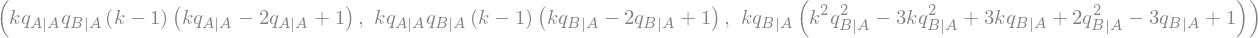

In [10]:
# multinomial distribution times k_AA**2*k_BA
test_AAAABA = summation(dist_A*k_AA**2*k_BA, (k_BA, 0, k))
test_AAAABA = cancel(test_AAAABA.args[0]*test_AAAABA.args[1].args[0][0]).subs({k: k - k_AA})
test_AAAABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AAAABA, (k_AA, 0, k))
test_AAAABA = cancel(test_AAAABA.args[0]*test_AAAABA.args[1].args[0][0])
test_AAAABA = simplify(test_AAAABA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_BA**2*k_AA
test_AABABA = summation(dist_A*k_AA*k_BA**2, (k_BA, 0, k))
test_AABABA = cancel(test_AABABA.args[0]*test_AABABA.args[1].args[0][0]).subs({k: k - k_AA})
test_AABABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AABABA, (k_AA, 0, k))
temps = [test_AABABA.args[i] for i in range(3)]
test_AABABA = cancel(np.sum([np.product([temps[i].args[j] 
                                         for j in range(np.size(temps[i].args) - 1)])*temps[i].args[-1].args[0][0] 
                             for i in range(3)]))
test_AABABA = simplify(test_AABABA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_BA**3
test_BABABA = summation(dist_A*k_BA**3, (k_BA, 0, k))
test_BABABA = cancel(test_BABABA.args[0][0]).subs({k: k - k_AA})
test_BABABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_BABABA, (k_AA, 0, k))
temps = [test_BABABA.args[i] for i in range(7)]
test_BABABA = cancel(np.sum([np.product([temps[i].args[j] 
                                         for j in range(np.size(temps[i].args) - 1)])*temps[i].args[-1].args[0][0] 
                             for i in range(7)]))
test_BABABA = simplify(test_BABABA.subs({p_e: 1 - q_AA - q_BA}))
test_AAAABA, test_AABABA, test_BABABA

In [11]:
# one-fold, two-fold, and three-fold (which need to be replaced indirectly by considering the detailed expressions)
## neighbors
### of an A individual
dist_A_subs = {'AA': k*q_AA, 'BA': k*q_BA, 'CA': k*p_e, 
               'AABA': k*(k - 1)*q_AA*q_BA, 
               'BACA': k*(k - 1)*q_BA*p_e, 'CAAA': k*(k - 1)*p_e*q_AA, 
               'AAAA': k*q_AA*((k - 1)*q_AA + 1), 'BABA': k*q_BA*((k - 1)*q_BA + 1), 'CACA': k*p_e*((k - 1)*p_e + 1), 
               'AAAABA': k*(k - 1)*q_AA*q_BA*((k - 2)*q_AA + 1), 
               'AABABA': k*(k - 1)*q_AA*q_BA*((k - 2)*q_BA + 1), 
               'BABABA': k*q_BA*(k*q_BA + ((k - 1)*q_BA + 1)*((k - 2)*q_BA + 1))}
### of a B individual
dist_B_subs = {'AB': k*q_AB, 'BB': k*q_BB, 'CB': k*p_e, 
               'ABBB': k*(k - 1)*q_AB*q_BB, 
               'BBCB': k*(k - 1)*q_BB*p_e, 'CBAB': k*(k - 1)*p_e*q_AB, 
               'ABAB': k*q_AB*((k - 1)*q_AB + 1), 'BBBB': k*q_BB*((k - 1)*q_BB + 1), 'CBCB': k*p_e*((k - 1)*p_e + 1),
               'ABBBBB': k*(k - 1)*q_BB*q_AB*((k - 2)*q_BB + 1), 
               'ABABBB': k*(k - 1)*q_BB*q_AB*((k - 2)*q_AB + 1), 
               'ABABAB': k*q_AB*(k*q_AB + ((k - 1)*q_AB + 1)*((k - 2)*q_AB + 1))}
# one-fold (which can be replaced directly)
## neighbors 
### of an A neighbor except for the focal individual
bist_A_subs = {l_AA: (k - 1)*q_AA, l_BA: (k - 1)*q_BA, l_CA: (k - 1)*p_e}
### of a B neighbor except for the focal individual
bist_B_subs = {l_AB: (k - 1)*q_AB, l_BB: (k - 1)*q_BB, l_CB: (k - 1)*p_e}

### Derivative of $p_A$: Equation (A25)-1
> $W_{A\to B}- W_{B\to A}$

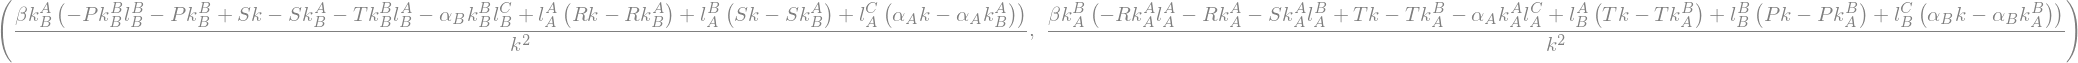

In [12]:
terms_AB0, terms_AB1
terms_AB1, terms_BA1

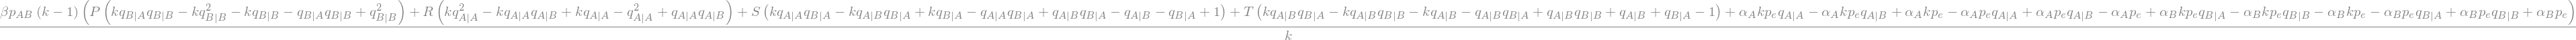

In [13]:
# integration of the core
## a focal B individual being replaced by a neighbor A individual: Equation (A19)
W_AB0 = factor(terms_AB0.coeff(k_AB, 1)*dist_B_subs['AB']) # constant term with the factor k_AB
W_AB1 = factor(terms_AB1.subs(bist_A_subs).subs(bist_B_subs)) # first-degree term
W_AB1 = expand(W_AB1)
coeff0 = factor(W_AB1.coeff(k_AB, 1).coeff(k_BB, 0)) # k_AB
coeff1 = factor(W_AB1.coeff(k_AB, 1).coeff(k_BB, 1)) # k_AB*k_BB
coeff2 = factor(W_AB1.coeff(k_AB, 2)) # k_AB**2
W_AB1 = factor(coeff0*dist_B_subs['AB'] + coeff1*dist_B_subs['ABBB'] + coeff2*dist_B_subs['ABAB'])
W_AB = p_B*(W_AB0 + W_AB1)
## a focal A individual being replaced by a neighbor B individual
W_BA0 = factor(terms_BA0.coeff(k_BA, 1)*dist_A_subs['BA']) # constant term with the factor k_BA
W_BA1 = factor(terms_BA1.subs(bist_A_subs).subs(bist_B_subs)) # first-degree term
W_BA1 = expand(W_BA1)
coeff0 = factor(W_BA1.coeff(k_BA, 1).coeff(k_AA, 0)) # k_BA
coeff1 = factor(W_BA1.coeff(k_BA, 1).coeff(k_AA, 1)) # k_AA*k_BA
coeff2 = factor(W_BA1.coeff(k_BA, 2)) # k_BA**2
W_BA1 = factor(coeff0*dist_A_subs['BA'] + coeff1*dist_A_subs['AABA'] + coeff2*dist_A_subs['BABA'])
W_BA = p_A*(W_BA0 + W_BA1)
# p_AB = p_A*q_BA = p_B*q_AB
p_A_diff = factor(W_AB.subs(p_B, p_AB/q_AB) - W_BA.subs(p_A, p_AB/q_BA))
collect(collect(collect(collect(p_A_diff, R), S), T), P)

### Derivative of $p_{AA}$: Equation (A25)-3
> $\frac{2}{k}(\phi_{A\to B}^{AA} - \phi_{B\to A}^{AA})$

In [14]:
# integration of the core
## a focal B individual being replaced by a neighbor A individual: Equation (A21)
### constant term with the factor k_AB**2
phi_AB0 = factor((k_AB*terms_AB0).coeff(k_AB, 2)*dist_B_subs['ABAB']) 
### first-degree term
phi_AB1 = factor((k_AB*terms_AB1).subs(bist_A_subs).subs(bist_B_subs)) 
phi_AB1 = expand(phi_AB1)
coeff0 = factor(phi_AB1.coeff(k_AB, 2).coeff(k_BB, 0)) # k_AB**2
coeff1 = factor(phi_AB1.coeff(k_AB, 2).coeff(k_BB, 1)) # k_AB**2*k_BB
coeff2 = factor(phi_AB1.coeff(k_AB, 3)) # k_AB**3
phi_AB1 = factor(coeff0*dist_B_subs['ABAB'] + coeff1*dist_B_subs['ABABBB'] + coeff2*dist_B_subs['ABABAB'])
phi_AB = p_B*(phi_AB0 + phi_AB1)
## a focal A individual being replaced by a neighbor B individual
### constant term with the factor k_AA*k_BA
phi_BA0 = factor((k_AA*terms_BA0).coeff(k_BA, 1).coeff(k_AA, 1)*dist_A_subs['AABA'])
### first-degree term
phi_BA1 = factor((k_AA*terms_BA1).subs(bist_A_subs).subs(bist_B_subs))
phi_BA1 = expand(phi_BA1)
coeff0 = factor(phi_BA1.coeff(k_BA, 1).coeff(k_AA, 1)) # k_AA*k_BA
coeff1 = factor(phi_BA1.coeff(k_BA, 1).coeff(k_AA, 2)) # k_AA**2*k_BA
coeff2 = factor(phi_BA1.coeff(k_BA, 2).coeff(k_AA, 1)) # k_AA*k_BA**2
phi_BA1 = factor(coeff0*dist_A_subs['AABA'] + coeff1*dist_A_subs['AAAABA'] + coeff2*dist_A_subs['AABABA'])
phi_BA = p_A*(phi_BA0 + phi_BA1)
# p_AB = p_A*q_BA = p_B*q_AB
p_AA_diff = factor(phi_AB.subs(p_B, p_AB/q_AB) - phi_BA.subs(p_A, p_AB/q_BA))

### Equation (A27) or Equation (4)

In [15]:
# given that the constant term of p_A_diff with respect to beta is zero 
# the constant term of p_AA_diff with respect to beta need to be zero as well
identity = cancel(factor(collect(expand(p_AA_diff), beta).coeff(beta, 0))/p_AB)
Eq(factor(1 - identity), 1)

### Equation (A29) or Equation (2)

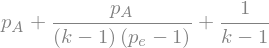

In [16]:
identity = identity.subs({q_AB: p_A/p_B*q_BA}).subs({q_BA: 1 - q_AA - p_e}).subs({p_B: 1 - p_A - p_e})
p_A + 1/(k - 1) + factor(solve(factor(identity), q_AA)[0] - p_A - 1/(k - 1))

## Main text

### Figure 1: Model schematic

In [17]:
def figure_lattice(L = 10, p_e_sub = 1/5, fsize = (8, 6), fs = 20):
    '''
    L: length of lattice
    p_e_sub: fraction of empty sizes
    fsize: figure size
    fs: font size
    '''
    data = np.concatenate([np.random.randint(1, 3, int(L**2*(1 - p_e_sub))), # random integers of 1 or 2
                           np.random.randint(0, 1, L**2 - int(L**2*(1 - p_e_sub)))]) # integers of 0
    random.shuffle(data)
    data = np.reshape(data, (L, L))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [3, 1]}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    palette = ['#F7F5EB', '#9CB4CC', '#F2D7D9'] # palette = ['#F7F5EB', '#A0C3D2', '#EAC7C7']
    cmap = mcolors.LinearSegmentedColormap.from_list('Custom', palette, len(palette))
    
    # subfigure: lattice
    img = sns.heatmap(data, square = True, cmap = cmap, alpha = 1, cbar = False, ax = ax0)
    ax0.set_xticklabels([])
    ax0.set_yticklabels([])
    # subfigure: legend
    ax1.axis('off')
    patch_0 = mpatches.Patch(color = palette[0], label = 'empty site')
    patch_1 = mpatches.Patch(color = palette[1], label = 'strategy ' + r'$A$')
    patch_2 = mpatches.Patch(color = palette[2], label = 'strategy ' + r'$B$')
    ax1.legend(handles = [patch_1, patch_2, patch_0], loc = 'center', ncol = 1, handleheight = 2, handlelength = 1.6, 
               bbox_to_anchor = (0.5, 0.5), fancybox = True, fontsize = fs - 4)

    plt.savefig(_Figure_PATH_ + 'fig1.png', dpi = 400, 
                facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

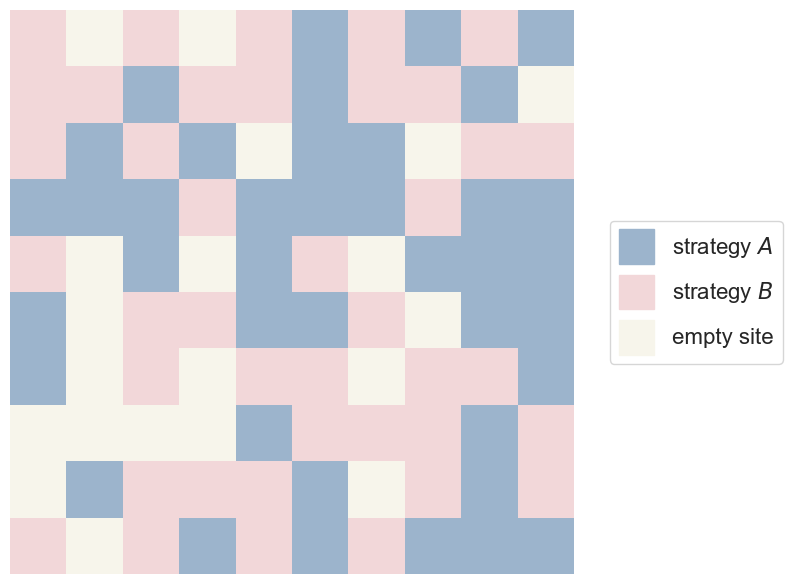

In [18]:
figure_lattice(fsize = (8.5, 6), fs = 20)

In [19]:
def initilization_lattice(L = 10, p_e_sub = 1/5):
    '''
    L: length of lattice
    p_e_sub: fraction of empty sizes
    '''
    # status
    N_e_sub = L*L
    N_sub = int(N_e_sub*(1 - p_e_sub))
    H = np.concatenate([np.random.randint(1, 3, int(L**2*(1 - p_e_sub))), # random integers of 1 or 2
                        np.random.randint(0, 1, L**2 - int(L**2*(1 - p_e_sub)))]) # integers of 0 (empty site)

    random.shuffle(H)
    G = nx.grid_2d_graph(L, L, periodic = True)
    for j, item in enumerate(G.nodes):
        G.nodes[item]['state'] = H[j]
    G_AB = G.subgraph([j for j, item in G.nodes(data = True) if item['state'] != 0])
    
    # !!! !!! !!! !!! all the non-empty sites are connected !!! !!! !!! !!!
    while not nx.is_connected(G_AB):
        random.shuffle(H)
        for j, item in enumerate(G.nodes):
            G.nodes[item]['state'] = H[j]
        G_AB = G.subgraph([j for j, item in G.nodes(data = True) if item['state'] != 0])
    
    A = nx.to_numpy_array(G)
    return H, A

def data_death_birth(L = 10, p_e_sub = 1/5, S_sub = -1, T_sub = 2, beta_sub = 0.005, u_sub = 0.001):
    '''
    L: length of lattice
    p_e_sub: fraction of empty sizes
    H: strategy distribution of the lattice
    A: adjacency matrix
    S_sub: payoff of cooperation against defection
    T_sub: payoff of defection against cooperation
    beta_sub: strength of selection
    u_sub: probability of mutation
    '''
    # parameters
    R_sub = 1
    P_sub = 0
    alpha_A_sub = alpha_B_sub = 0
    N_e_sub = L*L
    N_sub = int(N_e_sub*(1 - p_e_sub))
    # structure
    H0, A = initilization_lattice(L, p_e_sub)
    H = H0.copy()
    indices_AB = np.where(H0 != 0)[0]
    # payoff
    M = np.array([[0, 0, 0], [alpha_A_sub, R_sub, S_sub], [alpha_B_sub, T_sub, P_sub]])
    # fitness
    def fitness(l):
        neighbors = np.where(A[l] == 1)[0]
        return np.exp(beta_sub*np.sum([M[H[l]][H[nb]] for nb in neighbors]))
    # evolution
    t = 0 # generation
    T = int(1e6)
    abundances = np.zeros((2, T))
    while t < T:
        abundances[0, t] = np.sum(H == 1)
        abundances[1, t] = np.sum(H == 2)
        # focal individual
        j = random.choice(indices_AB)
        neighbors = np.where(A[j] == 1)[0]
        fitness_A = np.sum([fitness(l) if H[l] == 1 else 0 for l in neighbors]) 
        fitness_B = np.sum([fitness(l) if H[l] == 2 else 0 for l in neighbors])
        if random.uniform(0, 1) < u_sub: # mutation
            H[j] = 1 + int(random.uniform(0, 1) > 1/2)
        else: # no mutation
            if random.uniform(0, 1) < fitness_A/(fitness_A + fitness_B):
                H[j] = 1
            else:
                H[j] = 2
        t += 1
    abundances = abundances/N_sub
    return abundances

def figure_death_birth(abundances, L = 10, p_e_sub = 1/5, beta_sub = 0.005, u_sub = 0.001, fsize = (8, 6), fs = 20):
    '''
    L: length of lattice
    p_e_sub: fraction of empty sizes
    beta_sub: strength of selection
    u_sub: probability of mutation
    fsize: figure size
    fs: font size
    '''
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    palette = ['#F7F5EB', '#9CB4CC', '#F2D7D9'] # palette = ['#F7F5EB', '#A0C3D2', '#EAC7C7']
    labels = [r'$A$', r'$B$']
    # use a known color palette
    ts = np.linspace(0, np.shape(abundances)[1] - 1, np.shape(abundances)[1])
    ax.stackplot(ts[::1000], abundances[:, ::1000], colors = palette[1: ], alpha = 0.8, edgecolor = 'none', labels = labels)
    # ax.set_title('', fontsize = fs)
    ax.set_xlabel(r'$t$', fontsize = fs)
    ax.set_ylabel('abundance', fontsize = fs)
    plt.xticks(fontsize = fs - 2)
    plt.yticks(fontsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    # ax.legend(ncol = 2, loc='upper center', fancybox = True, fontsize = fs - 2)
    plt.savefig(_Figure_PATH_ + 'fig1X.png', dpi = 400, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')

In [20]:
stime = time.time()
abundances = data_death_birth()
etime = time.time()
print(str(round((etime - stime)/60)) + ' minutes')

0 minutes


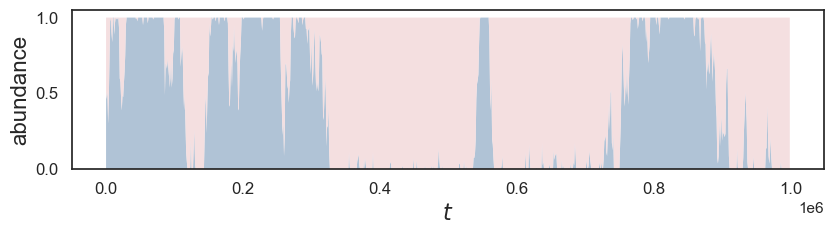

In [21]:
figure_death_birth(abundances, L = 10, p_e_sub = 1/5, beta_sub = 0.005, u_sub = 0.001, fsize = (8.5, 2.5), fs = 16)

### Equations (2 - 9)

In [22]:
# substitutions
q_AA_sub = p_A + 1/(k - 1) - p_A/((k - 1)*(1 - p_e)) # Equation (2)
q_BB_sub = p_B + 1/(k - 1) - p_B/((k - 1)*(1 - p_e)) # Equation (3)
q_BA_sub = p_B - p_B/((k - 1)*(1 - p_e)) # Equation (4)
q_AB_sub = p_A - p_A/((k - 1)*(1 - p_e)) # Equation (5)
pi_AA_sub = R + (k - 1)*(q_AA*R + q_BA*S + p_e*alpha_A) # Equation (6)
pi_BA_sub = T + (k - 1)*(q_AB*T + q_BB*P + p_e*alpha_B) # Equation (7)
pi_AB_sub = S + (k - 1)*(q_AA*R + q_BA*S + p_e*alpha_A)
pi_BB_sub = P + (k - 1)*(q_AB*T + q_BB*P + p_e*alpha_B)

n_AA, n_BA, n_AB, n_BB = k*q_AA, k*q_BA, k*q_AB, k*q_BB # number of neighbors
f_AA, f_BA, f_AB, f_BB = exp(beta*pi_AA), exp(beta*pi_BA), exp(beta*pi_AB), exp(beta*pi_BB) # fitness
T_A_backward = p_A*n_BA*f_BA/(n_AA*f_AA + n_BA*f_BA) # Equation (8)
T_A_forward = p_B*n_AB*f_AB/(n_AB*f_AB + n_BB*f_BB) # Equation (9)

### Equation (12): $\rho_A > 1/N$

In [23]:
# p_AB = p_A*q_BA = p_B*q_AB, 1 = p_A + p_B + p_e = q_AA + q_BA + p_e = q_AB + q_BB + p_e
ratio = factor(T_A_backward/T_A_forward).series(beta, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({p_A: p_AB/q_BA, p_B: p_AB/q_AB, q_BA: 1 - q_AA - p_e, q_AB: 1 - q_BB - p_e}))
remainder = factor((1 - ratio)*(1 - p_e)/beta)
collect(collect(remainder, q_AA), q_BB)

### Equation (13): $\rho_A > \rho_B$

In [24]:
ratio = factor(T_A_forward/T_A_backward).series(beta, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({p_A: p_AB/q_BA, p_B: p_AB/q_AB, q_BA: 1 - q_AA - p_e, q_AB: 1 - q_BB - p_e}))
remainder = factor((ratio - 1)*(1 - p_e)/beta)
collect(collect(remainder, q_AA), q_BB)

## From Discrete to Continuous

In [25]:
target = factor(remainder.subs({pi_AA: pi_AA_sub, pi_BA: pi_BA_sub, pi_AB: pi_AB_sub, pi_BB: pi_BB_sub, 
                                q_AA: q_AA_sub, q_BA: q_BA_sub, q_AB: q_AB_sub, q_BB: q_BB_sub}))
target = factor(target.subs({p_A: (1 - p_e)*i/N, p_B: (1 - p_e)*(N - i)/N}))
target = factor(target.subs({i: N*x}))

### Equation (14): $\rho_A > 1/N$

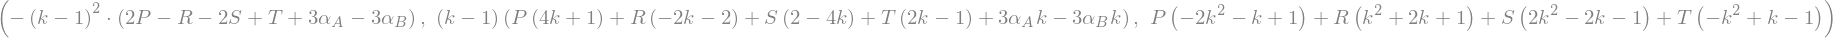

In [26]:
flag1 = fraction(factor(integrate(integrate(target.subs({x: y}), (y, 0, x)), (x, 0, 1))))[0]
flag12, flag11, flag10 = [factor(flag1.coeff(p_e, i)) for i in [2, 1, 0]]
flag12 = collect(collect(collect(collect(flag12, R), S), T), P)
flag11 = collect(collect(collect(collect(flag11, R), S), T), P)
flag10 = collect(collect(collect(collect(flag10, R), S), T), P)
flag12, flag11, flag10

### Equations (15 - 16): $\rho_A > \rho_B$

In [27]:
flag2 = factor_list(fraction(factor(integrate(target, (x, 0, 1))))[0])[1][1][0] # the first factor is always positive
flag21, flag20 = [factor(flag2.coeff(p_e, i)) for i in [1, 0]]
flag20 = collect(collect(collect(collect(flag20, R), S), T), P)
flag21, flag20

In [28]:
# alpha_A = alpha_B = 0
flag12, flag11, flag10 = [flag.subs({alpha_A: 0, alpha_B: 0}) for flag in [flag12, flag11, flag10]]
flag21, flag20 = [flag.subs({alpha_A: 0, alpha_B: 0}) for flag in [flag21, flag20]]

### Equations (17 - 18)

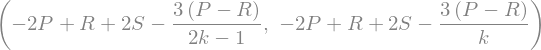

In [29]:
# open upwards or downwards: factor(flag12/(k - 1)**2)
# derivative at p_e = 0 positive or negative: factor(flag11/(k - 1))
tag_site_left = factor(solve(factor(flag11/(k - 1)), T)[0] - (R + 2*S - 2*P)) + (R + 2*S - 2*P)
# value at p_e = 1 positive or negative: factor((flag12 + flag11)/(k - 1))
tag_site_mid = factor(solve(factor((flag12 + flag11)/(k - 1)), T)[0] - (R + 2*S - 2*P)) + (R + 2*S - 2*P)
tag_site_left, tag_site_mid

### Equations (19 - 20)

In [30]:
# derivative at p_e = 1 positive or negative: factor((2*flag12 + flag11)/(k - 1))
tag_site_right = factor(solve(factor((2*flag12 + flag11)/(k - 1)), T)[0] - (R + 2*S - 2*P)) + (R + 2*S - 2*P)
tag_site_right

### Equation (22 - 23)

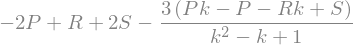

In [31]:
# in the absence of empty sites
tag_spatial = (R + 2*S - 2*P) + factor(solve(flag10, T)[0] - (R + 2*S - 2*P))
tag_spatial

### Intersection Point 
> of spatial structure and site dilution

### Equation (24)

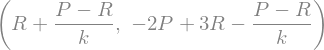

In [32]:
S_int = factor(solve(tag_spatial - tag_site_mid, S)[0] - R) + R
T_int = factor(tag_spatial.subs({S: S_int}) - 3*R + 2*P) + 3*R - 2*P
S_int, T_int

### Equation (25)

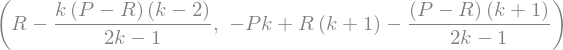

In [33]:
S_into = factor(solve(tag_spatial - tag_site_left, S)[0] - R) + R
T_into = factor(tag_spatial.subs({S: S_into}) - (k + 1)*R + k*P) + (k + 1)*R - k*P
S_into, T_into

### Figure 2: Dual impact of site dilution

In [34]:
def figure_dual_impact(R_sub, P_sub, k_sub, alpha_A_sub = 0, alpha_B_sub = 0, 
                       lw = 2, ms = 10, fsize = (6, 6), fs = 18):
    '''
    lw: line width
    ms: marker size
    fsize: figure size
    fs: font size
    '''
    flag1 = integrate(integrate(target.subs({x: y, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, 
                                             R: R_sub, P: P_sub, k: k_sub}), (y, 0, x)), (x, 0, 1))
    flag1 = fraction(factor(flag1))[0] # !!! does not change the result !!!
    flag12, flag11, flag10 = [factor(flag1.coeff(p_e, i)) for i in [2, 1, 0]]
    lam_site_negative = lambdify([S], solve(factor(flag11/(k - 1)), T)[0]) # Equation (18)-1
    lam_site_positive = lambdify([S], solve(factor((flag12 + flag11)/(k - 1)), T)[0]) # Equation (18)-2
    lam_spatial = lambdify([S], solve(flag10, T)[0]) # Equation (23)
    # intersection point of spatial structure and site dilution
    S_int = solve(solve(flag10, T)[0] - solve(factor((flag12 + flag11)/(k - 1)), T)[0], S)[0]
    
    S_subs = np.linspace(-1, 1, 201)
    
    a = [0.25, 0.4, 0.6, 0.8] # transparency
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, gridspec_kw = {'width_ratios': [2, 1, 1]}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    
    # main figure
    ax0.plot(S_subs, lam_spatial(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, lam_site_negative(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, lam_site_positive(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.fill_between(S_subs, lam_site_negative(S_subs), color = colors[0], alpha = a[1])
    ax0.fill_between(S_subs, lam_site_negative(S_subs), lam_site_positive(S_subs), color = colors[2], alpha = a[1])
    ax0.fill_between(S_subs, lam_site_positive(S_subs), lam_spatial(S_subs), color = colors[1], alpha = a[1])
    ax0.fill_between(S_subs, lam_spatial(S_subs), 2, color = colors[3], alpha = a[1])
    # prisoner's dilemma
    points = [[-1, 1], [0, 1], [0, 4], [-1, 4]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # snowdrift game
    points = [[0, 1], [1, 1], [1, 4], [0, 4]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # stag-hunt game
    points = [[-1, 0], [0, 0], [0, 1], [-1, 1]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # notations and arrows
    ax0.text(-0.75, 1.75, 'spatial effect', fontsize = fs - 2)
    ax0.text(-0.5, 0.25, 'site dilution effect', fontsize = fs - 2)
    kw = dict(arrowstyle = 'Simple, tail_width = 0.5, head_width = 8, head_length = 8', color = 'black')
    arrow_spatial = mpatches.FancyArrowPatch((-0.25, lam_spatial(-0.25)), (-0.5, 1.675), 
                                             connectionstyle = "arc3, rad = -0.25", **kw)
    ax0.add_patch(arrow_spatial)
    arrow_site_negative = mpatches.FancyArrowPatch((-0.325, lam_site_negative(-0.325)), (-0.25, 0.375), 
                                                   connectionstyle = "arc3, rad = -0.25", **kw)
    ax0.add_patch(arrow_site_negative)
    arrow_site_positive = mpatches.FancyArrowPatch((-0.5, lam_site_positive(-0.5)), (-0.375, 0.375), 
                                                   connectionstyle = "arc3, rad = -0.25", **kw)
    ax0.add_patch(arrow_site_positive)
    
    ax0.set_xlabel(r'$S$', fontsize = fs - 2)
    ax0.set_ylabel(r'$T$', fontsize = fs - 2)
    ax0.set_xlim([-1, 1])
    ax0.set_ylim([0, 2])
    ax0.set_xticks(np.arange(-1, 1.5, 0.5))
    ax0.set_yticks(np.arange(0, 2.5, 0.5))
    ax0.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax0.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    
    # sub figure: donation game
    S_subs = np.linspace(0.7, 0.8, 201)
    ax1.plot(S_subs, lam_spatial(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax1.plot(S_subs, lam_site_negative(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax1.plot(S_subs, lam_site_positive(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax1.fill_between(S_subs, lam_site_positive(S_subs), lam_spatial(S_subs), where = (S_subs < S_int), 
                     color = colors[1], alpha = a[2])
    ax1.fill_between(S_subs, lam_site_positive(S_subs), lam_spatial(S_subs), where = (S_subs > S_int), 
                     color = colors[4], alpha = a[2])
    ax1.fill_between(S_subs, np.max([lam_spatial(S_subs), lam_site_positive(S_subs)], axis = 0), 3.5, 
                     color = colors[3], alpha = a[1])
    ax1.fill_between(S_subs, np.min([lam_spatial(S_subs), lam_site_positive(S_subs)], axis = 0), 
                     color = colors[2], alpha = a[1])
    ax1.plot(S_int, lam_spatial(S_int), c = 'black', marker = 'o', markersize = ms, zorder = 600)
    points = [[0.74, 3.23], [0.76, 3.23], [0.76, 3.27], [0.74, 3.27]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax1.add_patch(square)
    ax1.set_xlabel('', fontsize = fs - 2)
    ax1.set_ylabel('', fontsize = fs - 2)
    ax1.set_xlim([0.74, 0.76])
    ax1.set_ylim([3.23, 3.27])
    ax1.set_xticks(np.arange(0.74, 0.76, 0.01))
    ax1.set_yticks(np.arange(3.23, 3.27, 0.01))
    ax1.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    
    # sub figure: legend
    ax2.axis('off')
    patch_pd = mpatches.Patch(color = colors[0], hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[1], 
                              label = "Prisoner's Dilemma")
    patch_sd = mpatches.Patch(color = colors[0], hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[1], 
                              label = "snowdrift game")
    patch_sh = mpatches.Patch(color = colors[0], hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[1], 
                              label = "stag-hunt game")
    patch0 = mpatches.Patch(color = colors[0], alpha = a[2], 
                             label = 'site dilution ' + r'$(-)$' + ', spatial structure ' + r'$(+)$')
    patch1 = mpatches.Patch(color = colors[2], alpha = a[2], 
                             label = 'site dilution ' + r'$(\pm)$' + ', spatial structure ' + r'$(+)$')
    patch2 = mpatches.Patch(color = colors[1], alpha = a[2], 
                             label = 'site dilution ' + r'$(+)$' + ', spatial structure ' + r'$(+)$')
    patch3 = mpatches.Patch(color = colors[3], alpha = a[2], 
                             label = 'site dilution ' + r'$(+)$' + ', spatial structure ' + r'$(-)$')
    patch4 = mpatches.Patch(color = colors[4], alpha = a[2], 
                             label = 'site dilution ' + r'$(\pm)$' + ', spatial structure ' + r'$(-)$')
    ax2.legend(handles = [patch_pd, patch_sd, patch_sh, patch0, patch1, patch2, patch3, patch4], 
               handleheight = 2, handlelength = 1.6, 
               loc = 'center', ncol = 1, bbox_to_anchor = (0.5, 0.5), fancybox = True, fontsize = fs - 6)
    
    plt.savefig(_Figure_PATH_ + 'fig2.png', dpi = 400, 
                facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

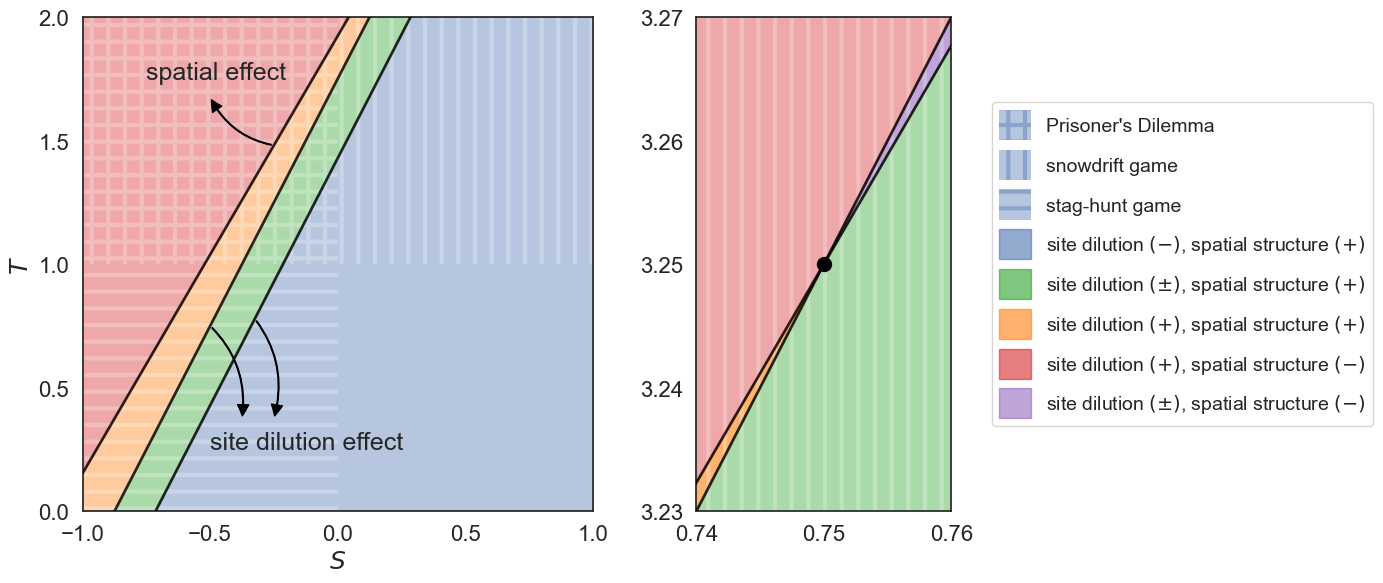

In [35]:
figure_dual_impact(R_sub = 1, P_sub = 0, k_sub = 4, lw = 2, ms = 10, fsize = (14, 6), fs = 20)

### Equation (26)

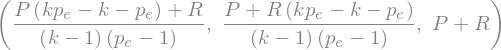

In [36]:
# the intersection point of rho_A = 1/N and rho_A = rho_B
eq_int = factor(flag1.subs({alpha_A: 0, alpha_B: 0}).subs({T: solve(flag2.subs({alpha_A: 0, alpha_B: 0}), T)[0]}))
eq_int = factor_list(fraction(eq_int)[0])[1][2][0]
S_int = factor(solve(eq_int, S)[0])
T_int = factor(solve(flag2.subs({alpha_A: 0, alpha_B: 0}), T)[0].subs({S: S_int}))
collect(collect(S_int, R), P), collect(collect(T_int, R), P), factor(S_int + T_int)

### Equation (27)

In [37]:
flag21.subs({T: R + S - P}), flag20, factor(flag20.subs({T: R + S - P})), factor(flag21 + flag20)

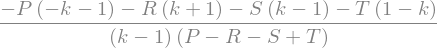

In [38]:
-flag20/flag21

### Whether the region of $\rho_A > 1/N$ is above or below the critical line of $\rho_A = 1/N$?

> below

In [39]:
coeff_T = flag1.coeff(T, 1) # a quadratic function of p_e: opening downward
factor(coeff_T.coeff(p_e, 1)**2 - 4*coeff_T.coeff(p_e, 2)*coeff_T.coeff(p_e, 0)) # b^2 - 4ac < 0

### Whether the region of $\rho_B > 1/N$ is to the left or right of the critical line of $\rho_B = 1/N$?

> left

### Whether the region of $\rho_A > \rho_B$ is above or below the critical line of $\rho_A = \rho_B$?

> below

In [40]:
factor(flag2.coeff(T, 1)) # a linear function of p_e

### Figure 3: Comparison of fixation probabilities

In [41]:
def figure_fixation(R_sub = 1, P_sub = 0, k_sub = 4, p_e_sub = 1/5, alpha_A_sub = 0, alpha_B_sub = 0, 
                    lw = 2, ms = 10, fsize = (8, 6), fs = 20):
    '''
    lw: line width
    ms: marker size
    fsize: figure size
    fs: font size
    '''
    # fixation probability of A
    flag1 = integrate(integrate(target.subs({x: y, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, 
                                             R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub}), (y, 0, x)), (x, 0, 1))
    
    lam_A = lambdify([S], solve(flag1, T)[0]) # below: > 1/N, above: < 1/N
    # fixation probability of B
    flag1 = integrate(integrate(target.subs({x: y, alpha_A: alpha_B_sub, alpha_B: alpha_A_sub, 
                                             R: P_sub, P: R_sub, k: k_sub, p_e: p_e_sub}), (y, 0, x)), (x, 0, 1))
    lam_B = lambdify([T], solve(flag1, S)[0]) # right: < 1/N, left: > 1/N
    # rho_A/rho_B
    flag2 = integrate(target.subs({alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, 
                                   R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub}), (x, 0, 1))
    lam_C = lambdify([S], solve(flag2, T)[0]) # below: rho_A > rho_B, above: rho_A < rho_B
    # intersection point of rho_A = rho_B = 1/N: Equation (26)
    S_int = (-R + (k*(1 - p_e) + p_e)*P)/((k - 1)*(1 - p_e))
    T_int = (-P + (k*(1 - p_e) + p_e)*R)/((k - 1)*(1 - p_e))
    S_int = S_int.subs({R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub})
    T_int = T_int.subs({R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub})
    
    if p_e_sub == 1/5:
        S_min, T_max = -1, 2
    elif p_e_sub == 4/5:
        S_min, T_max = -4, 5
    else:
        S_min, T_max = -4, 5
    S_subs = np.linspace(S_min, R_sub, 501)
    
    a = [0.2, 0.4, 0.6, 0.8]
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [3, 1]}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    
    ax0.plot(S_subs, lam_A(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, lam_B(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, lam_C(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    if p_e_sub == 1/5:
        ax0.fill_between(S_subs, P_sub, np.min([lam_A(S_subs), lam_B(S_subs)], axis = 0), 
                         color = colors[0], alpha = a[1])
        ax0.fill_between(S_subs, np.max([lam_A(S_subs), lam_B(S_subs)], axis = 0), T_max, 
                         color = colors[3], alpha = a[1])
        ax0.fill_between(S_subs, lam_B(S_subs), lam_C(S_subs), where = (S_subs > S_int), 
                         color = colors[2], alpha = a[2])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_A(S_subs), where = (S_subs > S_int), 
                         color = colors[4], alpha = a[2])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_A(S_subs), where = (S_subs < S_int), 
                         color = colors[1], alpha = a[2])
        ax0.fill_between(S_subs, lam_B(S_subs), lam_C(S_subs), where = (S_subs < S_int), 
                         color = colors[6], alpha = a[2])
    elif p_e_sub == 4/5:
        ax0.fill_between(S_subs, P_sub, np.min([lam_A(S_subs), lam_B(S_subs)], axis = 0), 
                         color = colors[0], alpha = a[1])
        ax0.fill_between(S_subs, np.max([lam_A(S_subs), lam_B(S_subs)], axis = 0), T_max, 
                         color = colors[3], alpha = a[1])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_B(S_subs), where = (S_subs < S_int), 
                         color = colors[2], alpha = a[2])
        ax0.fill_between(S_subs, lam_A(S_subs), lam_C(S_subs), where = (S_subs < S_int), 
                         color = colors[4], alpha = a[2])
        ax0.fill_between(S_subs, lam_A(S_subs), lam_C(S_subs), where = (S_subs > S_int), 
                         color = colors[1], alpha = a[2])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_B(S_subs), where = (S_subs > S_int), 
                         color = colors[6], alpha = a[2])
    else:
        ax0.fill_between(S_subs, lam_B(S_subs), lam_A(S_subs), where = (S_subs > S_int), 
                         color = colors[0], alpha = a[1])
        ax0.fill_between(S_subs, lam_A(S_subs), lam_B(S_subs), where = (S_subs < S_int), 
                         color = colors[3], alpha = a[1])
        ax0.fill_between(S_subs, P_sub, np.min([lam_B(S_subs), lam_C(S_subs)], axis = 0), 
                         color = colors[2], alpha = a[2])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_A(S_subs), where = (S_subs < S_int), 
                         color = colors[4], alpha = a[2])
        ax0.fill_between(S_subs, lam_A(S_subs), lam_C(S_subs), where = (S_subs > S_int), 
                         color = colors[1], alpha = a[2])
        ax0.fill_between(S_subs, np.max([lam_B(S_subs), lam_C(S_subs)], axis = 0), T_max, 
                         color = colors[6], alpha = a[2])
    
    # intersection point
    ax0.plot(S_int, T_int, c = 'black', marker = 'o', markersize = ms, zorder = 600)
    
    # prisoner's dilemma
    points = [[S_min, R_sub], [P_sub, R_sub], [P_sub, T_max], [S_min, T_max]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # snowdrift game
    points = [[P_sub, R_sub], [R_sub, R_sub], [R_sub, T_max], [P_sub, T_max]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # stag-hunt game
    points = [[S_min, P_sub], [P_sub, P_sub], [P_sub, R_sub], [S_min, R_sub]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # donation game
    line = plt.Line2D((S_min, P_sub), (T_max, R_sub), c = 'black', lw = lw, ls = '--', 
                      marker = '.', markersize = 0, alpha = a[3])
    ax0.add_line(line)
    
    # notations and arrows
    kw = dict(arrowstyle = 'Simple, tail_width = 0.5, head_width = 8, head_length = 8', color = 'black')
    if p_e_sub == 1/5:
        ax0.text(-0.625, 1.75, r'$\rho_A = 1/N$', fontsize = fs - 2)
        ax0.text(0.375, 1.5, r'$\rho_B = 1/N$', fontsize = fs - 2)
        ax0.text(-0.625, 0.5, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_A = mpatches.FancyArrowPatch((-0.3, lam_A(-0.3)), (-0.475, 1.675), 
                                           connectionstyle = "arc3, rad = -0.25", **kw)
        arrow_B = mpatches.FancyArrowPatch((0.1, lam_B(0.1)), (0.475, 1.675), 
                                           connectionstyle = "arc3, rad = -0.25", **kw)
        arrow_C = mpatches.FancyArrowPatch((-0.8, lam_C(-0.8)), (-0.475, 0.675), 
                                           connectionstyle = "arc3, rad = -0.25", **kw)
    elif p_e_sub == 4/5:
        ax0.text(-0.5, 2.375, r'$\rho_A = 1/N$', fontsize = fs - 2)
        ax0.text(-2, 4.25, r'$\rho_B = 1/N$', fontsize = fs - 2)
        ax0.text(-2.25, 0.3, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_A = mpatches.FancyArrowPatch((-0.3, lam_A(-0.3)), (-0.1, 2.75), 
                                           connectionstyle = "arc3, rad = -0.25", **kw)
        arrow_B = mpatches.FancyArrowPatch((-1.25, lam_B(-1.25)), (-1.5, 4), 
                                           connectionstyle = "arc3, rad = -0.25", **kw)
        arrow_C = mpatches.FancyArrowPatch((-2.5, lam_C(-2.5)), (-2, 0.675), 
                                           connectionstyle = "arc3, rad = -0.25", **kw)
    else:
        ax0.text(-0.65, 2.875, r'$\rho_A = 1/N$', fontsize = fs - 2)
        ax0.text(-2.4, 1.25, r'$\rho_B = 1/N$', fontsize = fs - 2)
        ax0.text(-2.4, 4.375, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_A = mpatches.FancyArrowPatch((0, lam_A(0)), (-0.25, 3.25), 
                                           connectionstyle = "arc3, rad = -0.25", **kw)
        arrow_B = mpatches.FancyArrowPatch((-2.75, lam_B(-2.75)), (-2, 1), 
                                           connectionstyle = "arc3, rad = 0.25", **kw)
        arrow_C = mpatches.FancyArrowPatch((-3, lam_C(-3)), (-2, 4.75), 
                                           connectionstyle = "arc3, rad = -0.25", **kw)
    ax0.add_patch(arrow_A)
    ax0.add_patch(arrow_B)
    ax0.add_patch(arrow_C)
    
    notations = {1/5: r'$1/5$', 4/5: r'$4/5$', 9/10: r'$9/10$'}
    ax0.set_title(r'$p_e = $' + notations[p_e_sub], fontsize = fs, y = 1.01)
    ax0.set_xlabel(r'$S$', fontsize = fs - 2)
    ax0.set_ylabel(r'$T$', fontsize = fs - 2)
    ax0.set_xlim([S_min, R_sub])
    ax0.set_ylim([P_sub, T_max])
    ax0.set_xticks(np.arange(S_min, R_sub + 0.5, (lambda x: 0.5 if x < 1/2 else 1)(p_e_sub)))
    ax0.set_yticks(np.arange(P_sub, T_max + 0.5, (lambda x: 0.5 if x < 1/2 else 1)(p_e_sub)))
    ax0.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax0.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    # sub figure: legend
    ax1.axis('off')
    patch_pd = mpatches.Patch(color = colors[0], hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[1], 
                              label = "Prisoner's Dilemma")
    patch_sd = mpatches.Patch(color = colors[0], hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[1], 
                              label = "snowdrift game")
    patch_sh = mpatches.Patch(color = colors[0], hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[1], 
                              label = "stag-hunt game")
    patch0 = mpatches.Patch(color = colors[2], alpha = a[2], label = r'$\rho_A > \rho_B > 1/N$')
    patch1 = mpatches.Patch(color = colors[0], alpha = a[2], label = r'$\rho_A > 1/N > \rho_B$')
    patch2 = mpatches.Patch(color = colors[1], alpha = a[2], label = r'$1/N > \rho_A > \rho_B$')
    patch3 = mpatches.Patch(color = colors[6], alpha = a[2], label = r'$1/N > \rho_B > \rho_A$')
    patch4 = mpatches.Patch(color = colors[3], alpha = a[2], label = r'$\rho_B > 1/N > \rho_A$')
    patch5 = mpatches.Patch(color = colors[4], alpha = a[2], label = r'$\rho_B > \rho_A$ > 1/N')
    ax1.legend(handles = [patch_pd, patch_sd, patch_sh, patch0, patch1, patch2, patch3, patch4, patch5], 
               handleheight = 2, handlelength = 1.6, 
               loc = 'center', ncol = 1, bbox_to_anchor = (0.5, 0.5), fancybox = True, fontsize = fs - 4)
    plt.savefig(_Figure_PATH_ + 'fig3_' + str(int(p_e_sub*10)) + '.png', dpi = 400, 
                facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

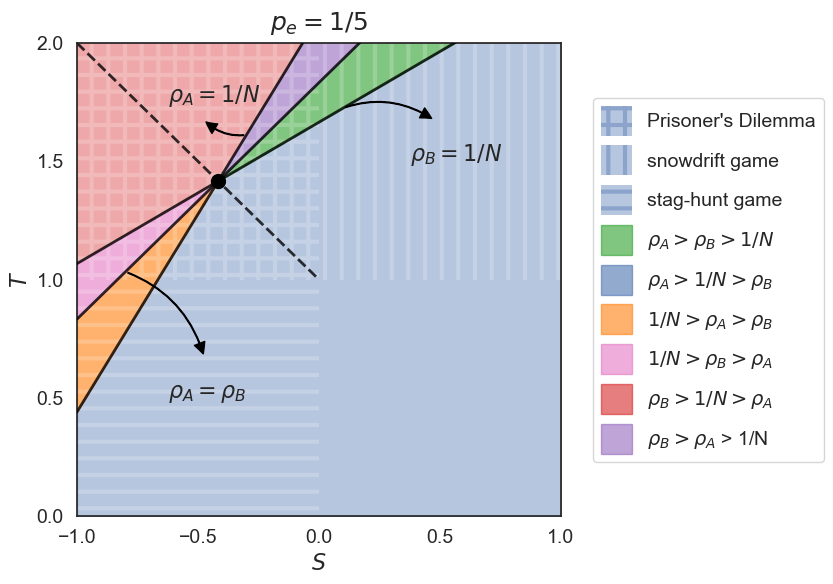

In [42]:
figure_fixation(fsize = (8.5, 6), fs = 18)

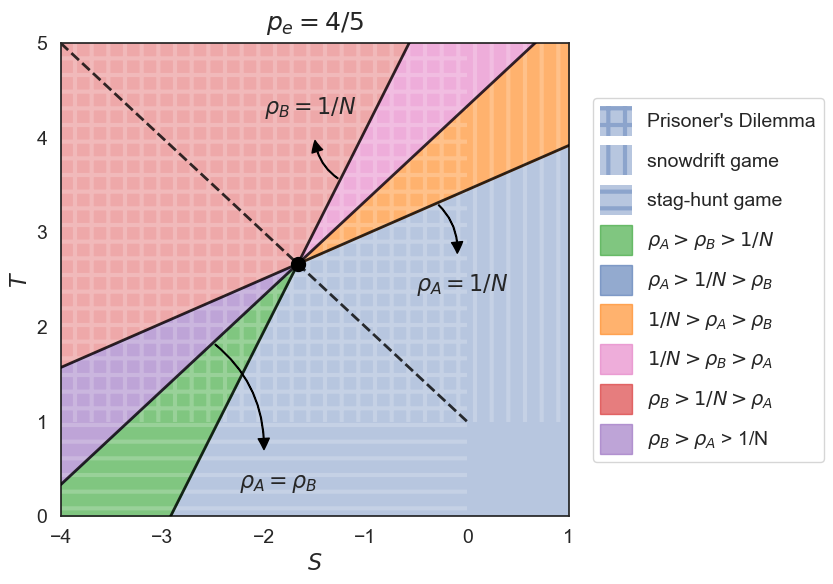

In [43]:
figure_fixation(p_e_sub = 4/5, fsize = (8.5, 6), fs = 18)

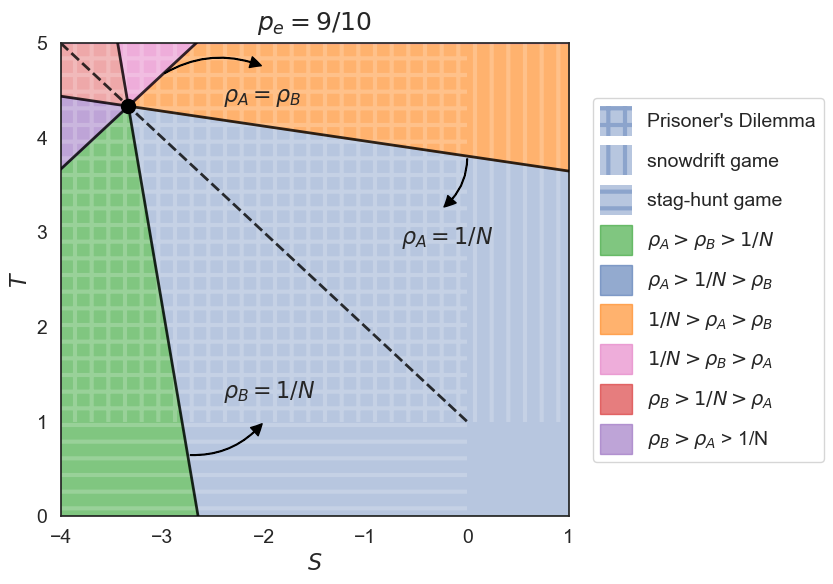

In [44]:
figure_fixation(p_e_sub = 9/10, fsize = (8.5, 6), fs = 18)

### Figure 4: Site dilution can boost or hinder the fixation of a single A

In [45]:
def figure_fixation_A(R_sub = 1, P_sub = 0, k_sub = 4, S_subs = [0], 
                      alpha_A_sub = 0, alpha_B_sub = 0, dg_sub = u, 
                      lw = 2, ms = 10, fsize = (6, 6), fs = 20):
    '''
    lw: line width
    ms: marker size
    fsize: figure size
    fs: font size
    '''
    # fixation probability of A
    flag1 = integrate(integrate(target.subs({x: y, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, 
                                             R: R_sub, P: P_sub, k: k_sub}), (y, 0, x)), (x, 0, 1))
    flag1 = fraction(factor(flag1))[0] # !!! does not change the result !!!
    
    T_max, u_max = 6, 5
    p_e_subs = np.linspace(0, 1, 2001)
    T_subs = np.linspace(0, T_max, 2001)
    u_subs = np.linspace(0, u_max, 2001)
    z, w = np.meshgrid(p_e_subs, T_subs)
    z_dg, w_dg = np.meshgrid(p_e_subs, u_subs)
    
    a = [0.2, 0.4, 0.6, 0.8]
    fig, axes = plt.subplots(nrows = 2, ncols = 2, 
                             gridspec_kw = {'width_ratios': [1]*2, 'height_ratios': [1]*2}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    
    # rho_A > 1/N
    # gain from site dilusion
    notations = [r'$-3/2$', r'$-1/2$', r'$1/2$'] # r'$2$'
    for j, S_sub in enumerate(S_subs):
        ax = axes[int(j/2)][j%2]
        lam_gain = lambdify([p_e, T], flag1.subs({S: S_sub}))
        ax.contourf(z, w, (lam_gain(z, w) > 0).astype(int), [0.99999, 1.00001], 
                    cmap = mcolors.ListedColormap([colors[0], colors[0]]), alpha = a[1])
        ax.set_title(r'$S = $' + notations[j], fontsize = fs)
        ax.set_xlabel(r'$p_e$', fontsize = fs - 2)
        ax.set_ylabel(r'$T$', fontsize = fs - 2)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, T_max])
        ax.set_xticks(np.arange(0, 1 + 0.2, 0.2))
        ax.set_yticks(np.arange(0, T_max + 1, 1))
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    
    # donation game
    j+= 1
    ax = axes[int(j/2)][j%2]
    lam_gain = lambdify([p_e, u], flag1.subs({S: -dg_sub, T: 1 + dg_sub}))
    points = [[0, 0], [1, 0], [1, u_max], [0, u_max]]
    # square = plt.Polygon(points, facecolor = 'none', hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[0])
    # ax.add_patch(square)
    ax.contourf(z_dg, w_dg, (lam_gain(z_dg, w_dg) > 0).astype(int), [0.99999, 1.00001],  
                cmap = mcolors.ListedColormap([colors[0], colors[0]]), alpha = a[1])
    cs = ax.contourf(z_dg, w_dg, (lam_gain(z_dg, w_dg) > 0).astype(int), 
                     colors = 'none', hatches = ['+'], extend = 'lower')
    cs.collections[0].set_facecolor('none')
    cs.collections[0].set_edgecolor('white')
    cs.collections[0].set_linewidth(0)
    cs.collections[-1].set_facecolor('none')
    cs.collections[-1].set_edgecolor('white')
    cs.collections[-1].set_linewidth(0)
    
    ax.set_title(r'$S = -u, T = 1 + u$', fontsize = fs)
    ax.set_xlabel(r'$p_e$', fontsize = fs - 2)
    ax.set_ylabel(r'$u$', fontsize = fs - 2)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, u_max])
    ax.set_xticks(np.arange(0, 1 + 0.2, 0.2))
    ax.set_yticks(np.arange(0, u_max + 1, 1))
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    
    plt.savefig(_Figure_PATH_ + 'fig4.png', dpi = 400, 
                facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

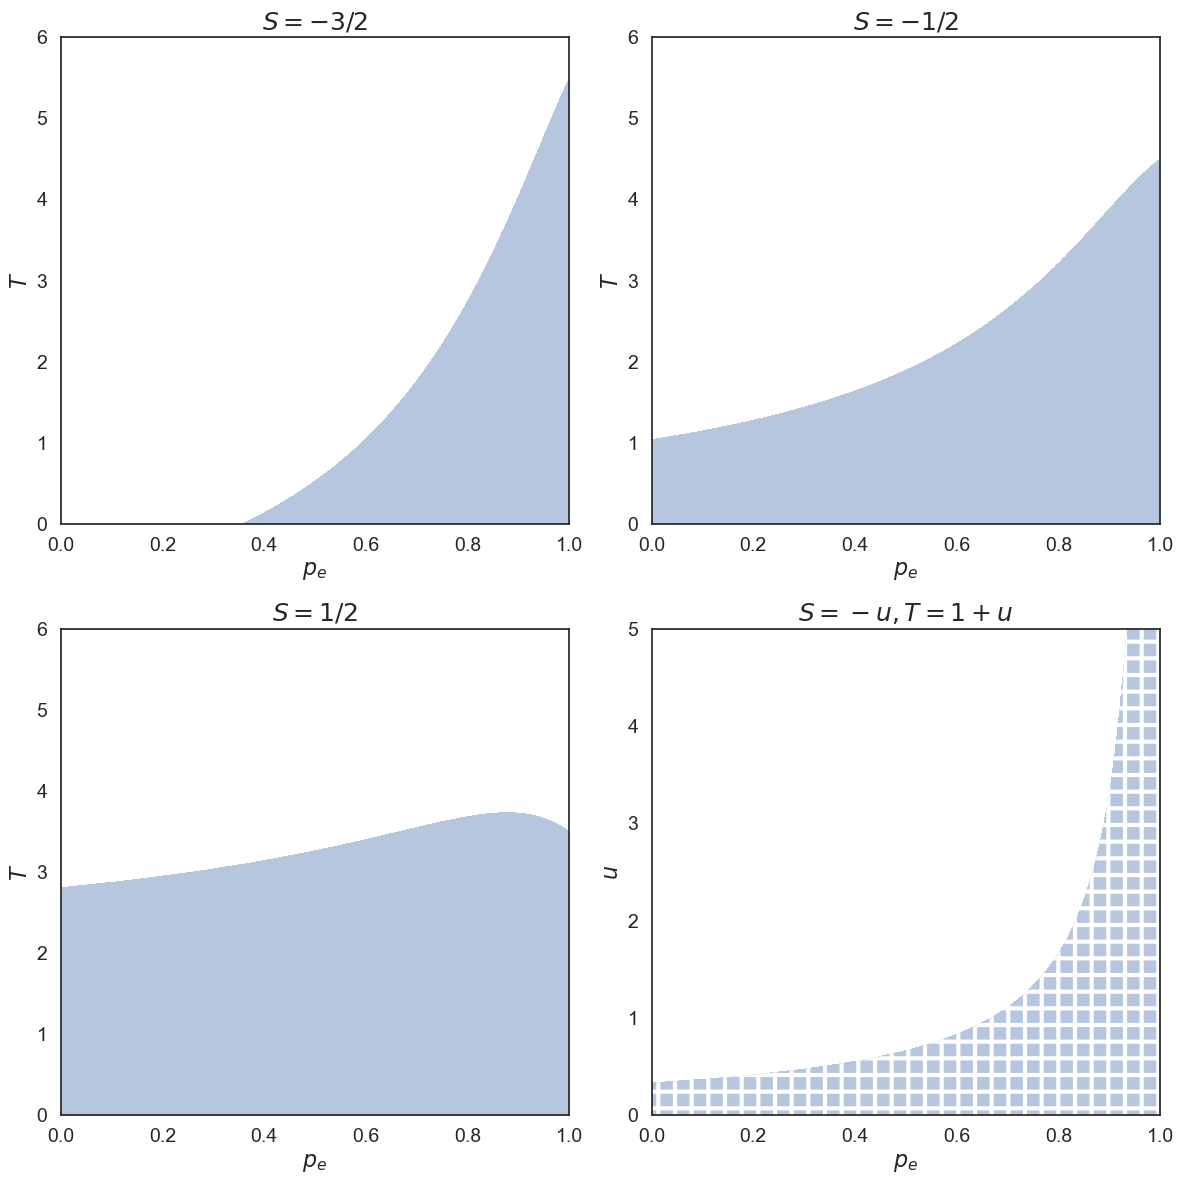

In [46]:
figure_fixation_A(S_subs = [-3/2, -1/2, 1/2], fsize = (12, 12), fs = 18)

## Agent-based simulation

> use notations $j$ and $l$ for indices to avoid conflicting with $i$ and $k$

In [47]:
def figure_lattice(L, W, H, fsize = (8, 6), fs = 20):
    '''
    observe whether the effective sites (As and Bs) are connected
    L: length of lattice
    W: width of the lattice
    H: strategy distribution of the lattice
    fsize: figure size
    fs: font size
    '''
    data = np.reshape(H, (L, W))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [3, 1]}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    palette = ['#F7F5EB', '#9CB4CC', '#F2D7D9']
    cmap = mcolors.LinearSegmentedColormap.from_list('Custom', palette, len(palette))
    
    # subfigure: lattice
    img = sns.heatmap(data, square = True, cmap = cmap, alpha = 1, cbar = False, ax = ax0)
    ax0.set_xticklabels([])
    ax0.set_yticklabels([])
    # subfigure: legend
    ax1.axis('off')
    patch_0 = mpatches.Patch(color = palette[0], label = 'empty site')
    patch_1 = mpatches.Patch(color = palette[1], label = 'strategy ' + r'$A$')
    patch_2 = mpatches.Patch(color = palette[2], label = 'strategy ' + r'$B$')
    ax1.legend(handles = [patch_1, patch_2, patch_0], loc = 'center', ncol = 1, 
               handleheight = 2, handlelength = 1.6, 
               bbox_to_anchor = (0.5, 0.5), fancybox = True, fontsize = fs - 4)
    plt.show()

In [48]:
def initilization_lattice(L = 10, W = 10, p_e_sub = 1/5, tag = 1):
    '''
    L: length of lattice
    W: width of the lattice
    p_e_sub: fraction of empty sizes
    beta_sub: strength of selection
    tag: 1 (A) or 2 (B)
    '''
    # status
    N_e_sub = L*W
    N_sub = int(N_e_sub*(1 - p_e_sub))
    H = np.concatenate([np.random.randint(tag, tag + 1, 1), # integers of tag
                        np.random.randint(3 - tag, 4 - tag, N_sub - 1), # integers of the other
                        np.random.randint(0, 1, N_e_sub - N_sub)]) # integers of 0 (empty site)
    random.shuffle(H)
    G = nx.grid_2d_graph(L, W, periodic = True)
    for j, item in enumerate(G.nodes):
        G.nodes[item]['state'] = H[j]
    G_AB = G.subgraph([j for j, item in G.nodes(data = True) if item['state'] != 0])
    
    # !!! !!! !!! !!! all the non-empty sites are connected !!! !!! !!! !!!
    while not nx.is_connected(G_AB):
        random.shuffle(H)
        for j, item in enumerate(G.nodes):
            G.nodes[item]['state'] = H[j]
        G_AB = G.subgraph([j for j, item in G.nodes(data = True) if item['state'] != 0])
    
    # adjacency matrix
#     A = np.zeros((N_e_sub, N_e_sub))
#     for j in range(N_e_sub):
#         A[j][j + 1 - W*((j + 1)%W == 0)] = 1
#         A[j][j - 1 + W*(j%W == 0)] = 1
#         A[j][(j + W)%N_e_sub] = 1   
#         A[j][(j - W)%N_e_sub] = 1
    # double-check
    # print((A == nx.to_numpy_array(G)).all()) 
    A = nx.to_numpy_array(G)
    return H, A
    
def fixation_sim(L, W, p_e_sub, S_sub, T_sub, beta_sub, tag):
    '''
    L: length of lattice
    W: width of the lattice
    H: strategy distribution of the lattice
    A: adjacency matrix
    p_e_sub: fraction of empty sizes
    beta_sub: strength of selection
    tag: 1 (A) or 2 (B)
    '''
    # parameters
    R_sub = 1
    P_sub = 0
    alpha_A_sub = alpha_B_sub = 0
    N_e_sub = L*W
    N_sub = int(N_e_sub*(1 - p_e_sub))
    # structure
    H0, A = initilization_lattice(L, W, p_e_sub, tag)
    H = H0.copy()
    indices_AB = np.where(H0 != 0)[0]
    # payoff
    M = np.array([[0, 0, 0], [alpha_A_sub, R_sub, S_sub], [alpha_B_sub, T_sub, P_sub]])
    # fitness
    def fitness(l):
        neighbors = np.where(A[l] == 1)[0]
        return np.exp(beta_sub*np.sum([M[H[l]][H[nb]] for nb in neighbors]))
    # evolution
    while (np.sum(H == 1) < N_sub) & (np.sum(H == 2) < N_sub):
        # focal individual
        j = random.choice(indices_AB)
        neighbors = np.where(A[j] == 1)[0]
        fitness_A = np.sum([fitness(l) if H[l] == 1 else 0 for l in neighbors]) 
        fitness_B = np.sum([fitness(l) if H[l] == 2 else 0 for l in neighbors])
        if random.uniform(0, 1) < fitness_A/(fitness_A + fitness_B):
            H[j] = 1
        else:
            H[j] = 2
    return (np.sum(H == tag) == N_sub)

### Test

> neutral drift

#### ❎ fixed network structure: does not work 

#### ✅ unfixed network structure: works

In [46]:
# population size: 50, effective population size: 40, 1/N = 0.025
L = 10
W = 5
p_e_sub = 1/5
S_sub = -1
T_sub = 2
rounds = int(1e5)
rhos = []
stime = time.time()
for tag in range(1, 3):
    with mp.Pool(int(mp.cpu_count() - 1)) as pool:
        results = np.array(pool.starmap(fixation_sim, [(L, W, p_e_sub, S_sub, T_sub, 0, tag)]*rounds))
        rhos.append(np.sum(results == 1)/rounds)
etime = time.time()
print('rho_A = ' + str(round(rhos[0], 6)) + ', ' + 'rho_B = ' + str(round(rhos[1], 6)))
print(str(round((etime - stime)/60)) + ' minutes')

# population size: 100, effective population size: 80, 1/N = 0.0125
L = 10
W = 10
p_e_sub = 1/5
S_sub = -1
T_sub = 2
rounds = int(1e5)
rhos = []
stime = time.time()
for tag in range(1, 3):
    with mp.Pool(int(mp.cpu_count() - 1)) as pool:
        results = np.array(pool.starmap(fixation_sim, [(L, W, p_e_sub, S_sub, T_sub, 0, tag)]*rounds))
        rhos.append(np.sum(results == 1)/rounds)
etime = time.time()
print('rho_A = ' + str(round(rhos[0], 6)) + ', ' + 'rho_B = ' + str(round(rhos[1], 6)))
print(str(round((etime - stime)/60)) + ' minutes')

rho_A = 0.02451, rho_B = 0.02501
2 minutes
rho_A = 0.01241, rho_B = 0.0121
4 minutes


## Numerical computation

In [49]:
ratio = T_A_backward/T_A_forward
ratio = factor(ratio.subs({pi_AA: pi_AA_sub, pi_BA: pi_BA_sub, pi_AB: pi_AB_sub, pi_BB: pi_BB_sub}))
ratio = factor(ratio.subs({q_BA: 1 - q_AA - p_e, q_AB: 1 - q_BB - p_e}))
ratio = factor(ratio.subs({q_AA: q_AA_sub, q_BB: q_BB_sub}))

def fixation_num(N_e_sub = 50, R_sub = 1, P_sub = 0, k_sub = 4, p_e_sub = 1/5, S_sub = -1, T_sub = 2, 
                 alpha_A_sub = 0, alpha_B_sub = 0, beta_sub = 0, tag = 1):
    '''
    N_e_sub: size of the population
    p_e_sub: fraction of empty sizes
    beta_sub: strength of selection
    tag: 1 (A) or 2 (B)
    '''
    ratio_temp = factor(ratio.subs({R: R_sub, P: P_sub, S: S_sub, T: T_sub}))
    ratio_temp = factor(ratio_temp.subs({k: k_sub, p_e: p_e_sub}))
    ratio_temp = factor(ratio_temp.subs({alpha_A: alpha_A_sub, alpha_B: alpha_B_sub}))
    ratio_temp = factor(ratio_temp.subs({beta: beta_sub}))
    def production(j):
        prod = np.prod([factor(ratio_temp.subs({p_A: l/N_e_sub, p_B: 1 - p_e_sub - l/N_e_sub})) \
                        for l in range(1, j + 1)])
        return prod
    
    N_sub = int(N_e_sub*(1 - p_e_sub))
    rho = 1/(1 + np.sum([production(j) for j in range(1, N_sub)]))
    if tag == 1: # rho_A
        return rho
    else: # rho_B
        return rho*production(N_sub - 1)

## Theoretical calculation

\begin{aligned}
\rho_A &= 1/[1 + \displaystyle\sum_{i = 1}^{N - 1}\displaystyle\prod_{j = 1}^{i}(1 - \beta\sigma_{ij})] \\
&\approx 1/[1 + \displaystyle\sum_{i = 1}^{N - 1}(1 - \displaystyle\sum_{j = 1}^{i}\beta\sigma_{ij})] = 1/(N - \displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\beta\sigma_{ij}) \\
&\approx 1/N + (\displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\beta\sigma_{ij})/N^2 
= 1/N + (\displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\beta\sigma_{ij}dydx)/(N^2dydx) 
\end{aligned}

* #### $\rho_A \approx 1/N + (\int_{0}^{1 - p_e}\int_{0}^{x}\beta\sigma_{ij}dydx)/(N^2dydx)
= 1/N + (\int_{0}^{1 - p_e}\int_{0}^{x}\beta\sigma_{ij}dydx)/(1 - p_e)^2$ ❓✔️
* #### $\rho_A \approx 1/N + (\int_{0}^{1}\int_{0}^{x}\beta\sigma_{ij}dydx)/(N^2dydx) 
= 1/N + (\int_{0}^{1}\int_{0}^{x}\beta\sigma_{ij}dydx)$❓✔️

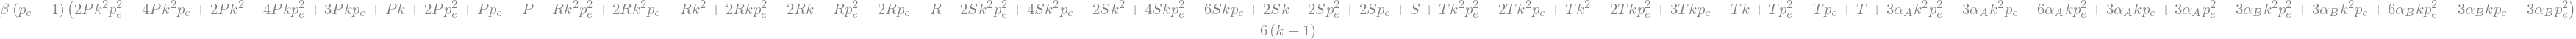

In [50]:
ratio = factor(T_A_backward/T_A_forward).series(beta, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({pi_AA: pi_AA_sub, pi_BA: pi_BA_sub, pi_AB: pi_AB_sub, pi_BB: pi_BB_sub, \
                           q_AA: q_AA_sub, q_BA: q_BA_sub, q_AB: q_AB_sub, q_BB: q_BB_sub}))
ratio = factor(ratio.subs({p_A: x, p_B: 1 - p_e - x}))
factor(integrate(integrate((1 - ratio).subs({x: y}), (y, 0, x)), (x, 0, 1 - p_e)))

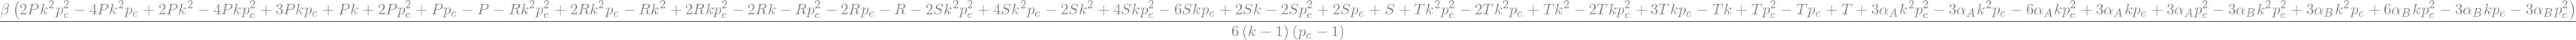

In [51]:
ratio = factor(T_A_backward/T_A_forward).series(beta, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({pi_AA: pi_AA_sub, pi_BA: pi_BA_sub, pi_AB: pi_AB_sub, pi_BB: pi_BB_sub, \
                           q_AA: q_AA_sub, q_BA: q_BA_sub, q_AB: q_AB_sub, q_BB: q_BB_sub}))
ratio = factor(ratio.subs({p_A: (1 - p_e)*x, p_B: (1 - p_e)*(1 - x)}))
factor(integrate(integrate((1 - ratio).subs({x: y}), (y, 0, x)), (x, 0, 1)))

In [52]:
# !!!!!! ?????? (1 - p_e)**2 ?????? !!!!!!
bonus = factor(integrate(integrate((1 - ratio).subs({x: y}), (y, 0, x)), (x, 0, 1)))
rho_formula = 1/N + bonus # correct
rho_formula_rescale = 1/N + factor((1 - p_e)**2*bonus) # incorrect

def fixation_thm(N_e_sub = 50, R_sub = 1, P_sub = 0, k_sub = 4, p_e_sub = 1/5, S_sub = -1, T_sub = 2, 
                 alpha_A_sub = 0, alpha_B_sub = 0, beta_sub = 0, tag = 1, rescale = False):
    '''
    rescale: True (times (1 - p_e)**2) or False
    '''
    N_sub = int(N_e_sub*(1 - p_e_sub))
    if rescale == True:
        rho = rho_formula_rescale.subs({N: N_sub, k: k_sub, p_e: p_e_sub, beta: beta_sub})
    else:
        rho = rho_formula.subs({N: N_sub, k: k_sub, p_e: p_e_sub, beta: beta_sub})
    if tag == 1:
        return rho.subs({R: R_sub, S: S_sub, T: T_sub, P: P_sub, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub})
    else:
        return rho.subs({R: P_sub, S: T_sub, T: S_sub, P: R_sub, alpha_A: alpha_B_sub, alpha_B: alpha_A_sub})

### Figure 5: Theoreical calculation vs Numerical computation vs Agent-based simulation

In [73]:
def figure_fixation(L = 10, W = 10, u_sub_star = 0, k_sub = 4, p_e_sub = 1/5, beta_sub = 0.005, ms = 200, 
                    fsize = (8, 6), fs = 20, rescale = False):
    '''
    rescale: True (times (1 - p_e)**2) or False
    '''
    N_sub = int(L*W*(1 - p_e_sub))
    rhos_nd = [1/N_sub for _ in u_subs]
    # u_sub_star_A = u_subs[min(enumerate(rhos_A), key = lambda rho: abs(rho[1] - 1/N_sub))[0]]
    # u_sub_star_B = u_subs[min(enumerate(rhos_B), key = lambda rho: abs(rho[1] - 1/N_sub))[0]]
    # print('A: ' + str(round(u_sub_star_A), 4) + ', B: ' + str(round(u_sub_star_B, 4)))
    palette = ['#F7F5EB', '#9CB4CC', '#F2D7D9']
    
    fig = plt.figure(figsize = fsize)
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
    
    plt.plot(u_subs, rhos_A, color = palette[1], alpha = 1, linewidth = 4, label = r'$\rho_A$') 
    plt.plot(u_subs, rhos_B, color = palette[2], alpha = 1, linewidth = 4, label = r'$\rho_B$')
    # plt.plot(u_subs_num, rhos_A_num, color = colors[0], linewidth = 2, linestyle = '--') 
    # plt.plot(u_subs_num, rhos_B_num, color = colors[3], linewidth = 2, linestyle = '--')
    plt.scatter(u_subs_sim, rhos_A_sim, s = ms, marker = 'v', c = palette[1], alpha = 1)
    plt.scatter(u_subs_sim, rhos_B_sim, s = ms, marker = '^', c = palette[2], alpha = 1)
    plt.plot(u_subs, rhos_nd, color = colors[7], linewidth = 2, linestyle = '--', label = r'$1/N$')
    plt.axvline(x = u_sub_star, ymin = 0.3, ymax = 0.7, color = colors[7], linewidth = 2, linestyle = '--')

    
    ax.set_xlabel(r'$u$', fontsize = fs - 2)
    ax.set_ylabel('fixation probability', fontsize = fs - 2)
    # ax.set_ylim(0.008, 0.014)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    ax.legend(loc = 'upper right', ncol = 1, fancybox = True, fontsize = fs - 4)
    notations = {1/20: r'$1/20$', 1/10: r'$1/10$', 1/5: r'$1/5$', 4/5: r'$4/5$', 9/10: r'$9/10$'}
    # r'$N_e = $' + str(L*W) + ', ' + r'$\beta = $' + str(beta_sub) + ',  ' + r'$k = $' + str(k_sub) + ',  ' + 
    plt.title(r'$p_e = $' + notations[p_e_sub], fontsize = fs, y = 1.01)
    if rescale == True:
        plt.savefig(_Figure_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                    '/fig5_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '_rescale.png', dpi = 400, 
                    facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    else:
        plt.savefig(_Figure_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                    '/fig5_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.png', dpi = 400, 
                    facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

### Example

* donation game: $(R, S, T, P) = (1, -u, 1 + u, 0)$
* population size: $10\times5 = 50$ or $10\times10 = 100$ or $20\times10 = 200$
* repetition: $40\times10^5 = 4$ million or $100\times10^5 = 10$ million
* lattice degree: $k = 4$
* emptysite fraction: $p_e = 1/20$, $p_e = 1/10$, or $p_e = 1/5 = 2/10$
* selection strength: $\beta = 0.005$

#### saving results

In [77]:
L = 10
W = 10
k_sub = 4
p_e_sub = 1/10
R_sub = 1
P_sub = 0
S_sub = -1
T_sub = 2
alpha_A_sub = alpha_B_sub = 0
beta_sub = 0.005
rounds = int(2*1e7)
# find when rho_A = rho_B
u_sub_star = solve((flag21*p_e + flag20).subs({R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub, S: -u, T: 1 + u}), u)[0]
u_sub_star = np.float64(u_sub_star)
print(round(u_sub_star, 4))

0.3704


In [78]:
u_subs_sim = np.array([0.3, 0.325, 0.35, u_sub_star, 0.4, 0.425, 0.45])
# u_subs_sim = np.array([0.3, 0.325, u_sub_star, 0.375, 0.4, 0.425, 0.45])
rhos_A_sim = []
stime = time.time()
for u_sub in u_subs_sim:
    with mp.Pool(int(mp.cpu_count() - 1)) as pool:
        results = np.array(pool.starmap(fixation_sim, [(L, W, p_e_sub, -u_sub, 1 + u_sub, beta_sub, 1)]*rounds))
        rhos_A_sim.append(np.sum(results == 1)/rounds)
etime = time.time()
print(str(round((etime - stime)/60**2, 2)) + ' hours') # 20 hours

rhos_B_sim = []
stime = time.time()
for u_sub in u_subs_sim:
    with mp.Pool(int(mp.cpu_count() - 1)) as pool:
        results = np.array(pool.starmap(fixation_sim, [(L, W, p_e_sub, -u_sub, 1 + u_sub, beta_sub, 2)]*rounds))
        rhos_B_sim.append(np.sum(results == 1)/rounds)
etime = time.time()
print(str(round((etime - stime)/60**2, 2)) + ' hours') # 20 hours

# save files
df_A = pd.DataFrame(list(zip(u_subs_sim, rhos_A_sim)), columns = ['u', 'rho'])
df_A.to_csv(_Data_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
            '/rhos_A_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.csv', sep = '\t')
df_B = pd.DataFrame(list(zip(u_subs_sim, rhos_B_sim)), columns = ['u', 'rho'])
df_B.to_csv(_Data_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
            '/rhos_B_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.csv', sep = '\t')

51.37 hours
52.1 hours


In [79]:
u_subs_num = np.linspace(0.3, 0.45, 301)
stime = time.time()
rhos_A_num = [fixation_num(L*W, R_sub, P_sub, k_sub, p_e_sub, 
                           -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, beta_sub, 1) for u_sub in u_subs_num]
rhos_B_num = [fixation_num(L*W, R_sub, P_sub, k_sub, p_e_sub, 
                           -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, beta_sub, 2) for u_sub in u_subs_num]
etime = time.time()
print(str(round((etime - stime)/60**2, 2)) + ' hours') # 10 minutes

# save files
df_A = pd.DataFrame(list(zip(u_subs_num, rhos_A_num)), columns = ['u', 'rho'])
df_A.to_csv(_Data_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
            '/rhos_A_' + str(int(1e3*beta_sub)) + '.csv', sep = '\t')
df_B = pd.DataFrame(list(zip(u_subs_num, rhos_B_num)), columns = ['u', 'rho'])
df_B.to_csv(_Data_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
            '/rhos_B_' + str(int(1e3*beta_sub)) + '.csv', sep = '\t')

1.36 hours


#### reading results

In [74]:
L = 10
W = 10
k_sub = 4
p_e_sub = 1/10
R_sub = 1
P_sub = 0
S_sub = -1
T_sub = 2
alpha_A_sub = alpha_B_sub = 0
beta_sub = 0.005
rounds = int(2*1e7)
# agent-based simulation
df_A = pd.read_csv(_Data_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                   '/rhos_A_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.csv', sep = '\t')
df_B = pd.read_csv(_Data_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                   '/rhos_B_' + str(int(1e3*beta_sub)) + '_' + 
                   str(int(rounds/1e5)) + '.csv', sep = '\t')
u_subs_sim = df_A['u'].to_numpy()
rhos_A_sim = df_A['rho'].to_numpy()
rhos_B_sim = df_B['rho'].to_numpy()
# numerical computation
df_A = pd.read_csv(_Data_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                   '/rhos_A_' + str(int(1e3*beta_sub)) + '.csv', sep = '\t')
df_B = pd.read_csv(_Data_PATH_ + 'p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                   '/rhos_B_' + str(int(1e3*beta_sub)) + '.csv', sep = '\t')
u_subs_num = df_A['u'].to_numpy()
rhos_A_num = df_A['rho'].to_numpy()
rhos_B_num = df_B['rho'].to_numpy()

0.24 seconds


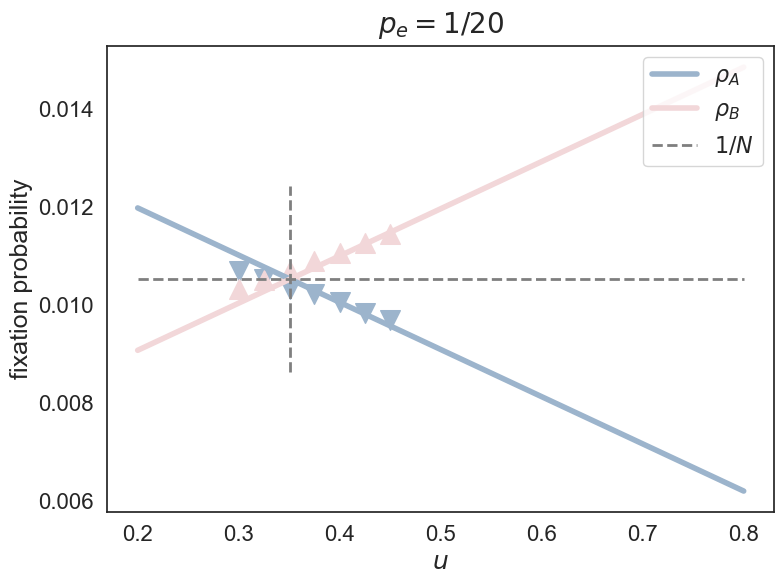

In [75]:
# theoretical calculation
u_subs = np.linspace(0.3, 0.45, 301)
u_subs = np.linspace(0.2, 0.8, 201)
stime = time.time()
rhos_A = [fixation_thm(L*W, R_sub, P_sub, k_sub, p_e_sub, 
                       -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, beta_sub, 1, rescale = False) 
          for u_sub in u_subs]
rhos_B = [fixation_thm(L*W, R_sub, P_sub, k_sub, p_e_sub, 
                       -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, beta_sub, 2, rescale = False) 
          for u_sub in u_subs]
etime = time.time()
print(str(round((etime - stime), 2)) + ' seconds')
figure_fixation(L, W, u_sub_star, k_sub, p_e_sub, beta_sub)

In [ ]:
# theoretical calculation
u_subs = np.linspace(0.3, 0.45, 301)
u_subs = np.linspace(0.2, 0.8, 201)
stime = time.time()
rhos_A = [fixation_thm(L*W, R_sub, P_sub, k_sub, p_e_sub, 
                       -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, beta_sub, 1, rescale = True) 
          for u_sub in u_subs]
rhos_B = [fixation_thm(L*W, R_sub, P_sub, k_sub, p_e_sub, 
                       -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, beta_sub, 2, rescale = True) 
          for u_sub in u_subs]
etime = time.time()
print(str(round((etime - stime), 2)) + ' seconds')
figure_fixation(L, W, u_sub_star, k_sub, p_e_sub, beta_sub, rescale = True)